####**Load Data**

In [ ]:
# Install required packages
!pip install datasets --quiet

In [ ]:
# Find Colab environment
import os

colab_env = os.environ.get('GOOGLE_CLOUD_PROJECT')
if colab_env == None:
    print("Using Colab Research")
else:
    print("Using Colab Enterprise")

Using Colab Enterprise


In [ ]:
# Login to Hugging Face
from huggingface_hub import login

if colab_env == None:
    # Get access token from Hugging Face hub
    from google.colab import userdata

    HF_TOKEN = userdata.get('HF_TOKEN')
else:
    # Get access token from Secret Manager
    !pip install google-cloud-secret-manager --quiet
    from google.cloud import secretmanager

    client = secretmanager.SecretManagerServiceClient()
    project_id = !gcloud config get-value project
    secret_name = f"projects/{project_id[0]}/secrets/HF_TOKEN/versions/latest"
    response = client.access_secret_version(request={"name": secret_name})
    HF_TOKEN = response.payload.data.decode("UTF-8")

if HF_TOKEN:
    login(HF_TOKEN)
    print("Successfully logged in to Hugging Face!")
else:
    print("Token is not set. Please set the token first.")

Successfully logged in to Hugging Face!


In [ ]:
# Load Hugging Face tokenized dataset dict anjan-k/Sentiment-Analysis-Tokenized
from datasets import load_dataset

sentiment_analysis_tokenized = load_dataset("anjan-k/Sentiment-Analysis-Tokenized")
print("Tokenized sentiment analysis dataset dict:")
print(sentiment_analysis_tokenized)

Tokenized sentiment analysis dataset dict:
DatasetDict({
    train: Dataset({
        features: ['id', 'text', 'label', 'sentiment', 'input_ids', 'attention_mask'],
        num_rows: 31232
    })
    validation: Dataset({
        features: ['id', 'text', 'label', 'sentiment', 'input_ids', 'attention_mask'],
        num_rows: 5205
    })
    test: Dataset({
        features: ['id', 'text', 'label', 'sentiment', 'input_ids', 'attention_mask'],
        num_rows: 5206
    })
})


In [ ]:
# Get tokenized test dataset
tokenized_test = sentiment_analysis_tokenized["test"]

In [ ]:
# Load model and tokenizer
from transformers import AutoTokenizer, AutoModelForSequenceClassification

def load_model_and_tokenizer(model_name):
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    model = AutoModelForSequenceClassification.from_pretrained(model_name)
    return model, tokenizer

In [ ]:
# Use a data_collator to convert training samples to PyTorch tensors
from transformers import DataCollatorWithPadding
def get_data_collator(tokenizer):
    data_collator = DataCollatorWithPadding(tokenizer=tokenizer)
    return data_collator

In [ ]:
import torch
from torch.utils.data import DataLoader

def get_dataloader(tokenized_test, batch_size, data_collator):
    # Set batch size
    batch_size = 16

    # Convert tokenized dataset to PyTorch tensors format
    tokenized_test.set_format(type='torch', columns=['input_ids', 'attention_mask', 'label'])

    # Setup dataloaders
    dataloader_test = DataLoader(tokenized_test, batch_size=batch_size, collate_fn=data_collator)
    return dataloader_test

In [ ]:
# Evaluate the model and report accuracy and f1-score

import torch
from sklearn.metrics import accuracy_score, f1_score

def evaluate_model(model, dataloader_test):
    # Use GPU if available
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)

    model.eval()
    all_preds = []
    all_labels = []

    # Evaluate loop
    with torch.no_grad():
        for batch in dataloader_test:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            logits = outputs.logits
            preds = torch.argmax(logits, dim=1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Calculate accuracy and F1 score
    accuracy = accuracy_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds, average='weighted')

    print(f"Accuracy: {accuracy:.4f}")
    print(f"F1 Score: {f1:.4f}")
    return accuracy, f1

In [ ]:
def run_evaluation(model_name, tokenized_test):
    model, tokenizer = load_model_and_tokenizer(model_name)
    data_collator = get_data_collator(tokenizer)
    dataloader_test = get_dataloader(tokenized_test=tokenized_test, batch_size=16, data_collator=data_collator)
    accuracy, f1 = evaluate_model(model, dataloader_test)
    return accuracy, f1

In [ ]:
model_name = "distilbert/distilbert-base-uncased"
accuracy_distilbert, f1_distilbert = run_evaluation(model_name, tokenized_test)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert/distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Accuracy: 0.3707
F1 Score: 0.2005


In [ ]:
model_name = "anjan-k/Sentiment-Analysis-FineTune-Torch"
accuracy_finetune_torch, f1_finetune_torch = run_evaluation(model_name, tokenized_test)

Accuracy: 0.7624
F1 Score: 0.7629


In [ ]:
model_name = "anjan-k/Sentiment-Analysis-FineTune-HuggingFace"
accuracy_finetune_hf, f1_finetune_hf = run_evaluation(model_name, tokenized_test)

Accuracy: 0.7630
F1 Score: 0.7632


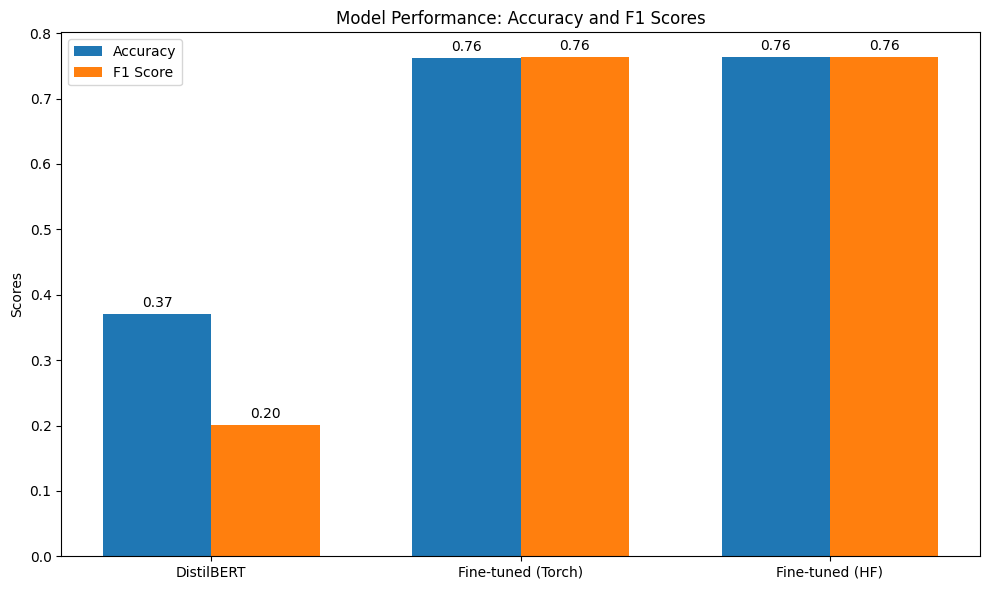

In [ ]:
# Generate a histogram with the accuracy and F1 scores

import matplotlib.pyplot as plt
import numpy as np

# Data for the histogram
models = ['DistilBERT', 'Fine-tuned (Torch)', 'Fine-tuned (HF)']
accuracies = [accuracy_distilbert, accuracy_finetune_torch, accuracy_finetune_hf]
f1_scores = [f1_distilbert, f1_finetune_torch, f1_finetune_hf]

x = np.arange(len(models))
width = 0.35

fig, ax = plt.subplots(figsize=(10, 6))
rects1 = ax.bar(x - width/2, accuracies, width, label='Accuracy')
rects2 = ax.bar(x + width/2, f1_scores, width, label='F1 Score')

# Set labels, title and axes ticks
ax.set_ylabel('Scores')
ax.set_title('Model Performance: Accuracy and F1 Scores')
ax.set_xticks(x)
ax.set_xticklabels(models)
ax.legend()

# Add the values on top of the bars
def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.2f}',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)

fig.tight_layout()
plt.show()